# 이번 코드의 특징 
## 1) 이번엔 shift(-1)로 한칸 당겨서 계산했습니다. why: 인덱싱이 더 직관적
## 2) 로그 수익률을 그대로 사용했습니다. np.exp(누적로그수익률) -> 1+누적로그수익률
## 3) 종혁님의 종목을 사용해서 진행했습니다. 따라서 이상치 문제는 없어 코드가 짧습니다. 

In [67]:
import pykrx
from pykrx import stock
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#help(pykrx)

In [114]:
# 1. 데이터 소개

# bond도 가능함
# from pykrx import bond

# https://github.com/sharebook-kr/pykrx

# tickers = stock.get_market_ticker_list(조회일자(YYYYmmdd) [,market=조회할 시장(KOSPI, KOSDAQ, ALL])
# name = get_market_ticker_name(심볼 [,market=조회할 시장(KOSPI, KOSDAQ, ALL])
# ohlcv = stock.stock.get_market_ohlcv(조회일자(YYYYmmdd) [,앞에 시작일을 넣었다면 종료일] [,심볼] )

# 예시

start_date= '20130101'
end_date= '20221231'
ticker = '002310'     #아세아제지
name= stock.get_market_ticker_name(ticker)

ohlcv = stock.get_market_ohlcv("20220222", market="KOSPI") # 특정일 코스피 종목들의 OHLCV
raw = stock.get_market_ohlcv(start_date,end_date,ticker) # 특정기간 특정 종목의 OHLCV

In [115]:
# 코스피 상장 기업 리스트 데이터셋

tickers = stock.get_market_ticker_list("20220222", market="KOSPI") # 코스피 종목 리스트
names = [stock.get_market_ticker_name(i) for i in tickers]         # 티커 -> 기업 이름


kospi_listed= pd.DataFrame({'ticker': tickers , 'name': names  })
kospi_listed


,ticker,name
0,095570,AJ네트웍스
1,006840,AK홀딩스
2,027410,BGF
3,282330,BGF리테일
4,138930,BNK금융지주
...,...,...
935,069260,TKG휴켐스
936,000540,흥국화재
937,000547,흥국화재2우B
938,000545,흥국화재우


In [116]:
# 잘 대응되었나 확인

kospi_listed[ kospi_listed['ticker'] == ticker ]

,ticker,name
548,002310,아세아제지


In [117]:
raw.tail()

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2022-12-23,39050,39400,38350,39150,29839,1161280550,-0.13
2022-12-26,39000,39600,38750,39400,14244,560669350,0.64
2022-12-27,39100,39450,38700,39400,28728,1122859400,0.00
2022-12-28,39200,39850,38650,39700,36691,1446375450,0.76
2022-12-29,39700,39700,38950,39400,20007,786583900,-0.76


In [118]:
 # 2. 수익률 계산하기
df=pd.DataFrame(raw['종가'])
df=df.rename(columns={'종가':'close'})

In [119]:
df.head()

,close
날짜,
2013-01-02,15000
2013-01-03,15000
2013-01-04,14950
2013-01-07,14850
2013-01-08,14850


## 이번 코드에선 shift(-1) 뒤로 한칸 땡겨서 해보기

In [120]:
df['close'].shift(-1) # shift(-1)로 하면 마지막에 NA

날짜
2013-01-02    15000.0
2013-01-03    14950.0
2013-01-04    14850.0
2013-01-07    14850.0
2013-01-08    14900.0
               ...   
2022-12-23    39400.0
2022-12-26    39400.0
2022-12-27    39700.0
2022-12-28    39400.0
2022-12-29        NaN
Name: close, Length: 2461, dtype: float64

In [121]:
# 헷갈리니까 열을 만들어서

df['close_tomorrow'] = df['close'].shift(-1)

In [122]:
df.head()

,close,close_tomorrow
날짜,,
2013-01-02,15000,15000.0
2013-01-03,15000,14950.0
2013-01-04,14950,14850.0
2013-01-07,14850,14850.0
2013-01-08,14850,14900.0


In [123]:
# Real Return column 생성

df['return']= np.log( df['close'].shift(-1)/df['close'] )

df.tail()

,close,close_tomorrow,return
날짜,,,
2022-12-23,39150,39400.0,0.006365
2022-12-26,39400,39400.0,0.000000
2022-12-27,39400,39700.0,0.007585
2022-12-28,39700,39400.0,-0.007585
2022-12-29,39400,NaN,NaN


In [126]:
# 수익률 계산 인덱싱 점검 (수익률 계산은 로그 리턴 근사를 그대로 이용) -> shift(1) 보다 훨씬 인덱싱이 친절함.

39150 * (1+ 0.006365 ) 

39399.18975

In [127]:
39400 * (1 + 0.007585 )

39698.848999999995

**로그리턴 근사 수익률로 곱한 것을 close_tomorrow 열과 비교해보니 얼추 맞는 것 같음.**

**좀 더 통계적으로 엄밀히 증명하고자 한다면 -> T-test**

In [128]:
# 우선 계산 값을 열로 추가해 놓기

df['close_tomorrow_computed'] = df['close'] * (1+df['return'])
df

# 추후에 조작한 열들 다 정리하고 싶으면
# df.drop(['return','close_tomorrow', 'close_tomorrow_computed'], axis=1, inplace=True)


,close,close_tomorrow,return,close_tomorrow_computed
날짜,,,,
2013-01-02,15000,15000.0,0.000000,15000.000000
2013-01-03,15000,14950.0,-0.003339,14949.916481
2013-01-04,14950,14850.0,-0.006711,14849.664053
2013-01-07,14850,14850.0,0.000000,14850.000000
2013-01-08,14850,14900.0,0.003361,14899.916013
...,...,...,...,...
2022-12-23,39150,39400.0,0.006365,39399.205170
2022-12-26,39400,39400.0,0.000000,39400.000000
2022-12-27,39400,39700.0,0.007585,39698.863633


In [129]:
# T test (통계적으로 두 컬럼이 같은지 검증)

import scipy.stats as stats

# Define your two columns as NumPy arrays or Pandas Series
column1 = df['close_tomorrow']
column2 = df['close_tomorrow_computed']

# Perform the t-test
_, p_value = stats.ttest_rel(column1, column2)

# Interpret the p-value

alpha = 0.05  # Set the significance level

if p_value < alpha:
    print("Reject the null hypothesis - the columns are statistically different.")
else:
    print("Fail to reject the null hypothesis - the columns are statistically similar.")


Fail to reject the null hypothesis - the columns are statistically similar.


### 따라서 로그 근사 수익률을 백분율 처럼 사용해도 되겠다!

In [130]:
# 3. 21년 말일 이후 향후 251일 이후의 수익률 부트스트래핑  (12월 31일은 주식시장 휴장일이다.)

# sampling with replacement (복원추출)
expect = np.random.choice(df['return'][:-1],size=251)  # df['return'][:-1] -> 마지막 행의 NA 추출에서 제외

In [131]:
# 4번

# 원 데이터의 마지막 값을 기준점으로 삼는다. 

init_price = df['close'][-1]

# 부트스트랩 수익률의 누적합을 구한다. 

cum_expect = np.cumsum(expect)

# 이를 통해 구해진 이후 251일치의 예측 종가 

predict= init_price * (1+cum_expect)        ## 로그 리턴을 그대로 수익률로 사용해 계산


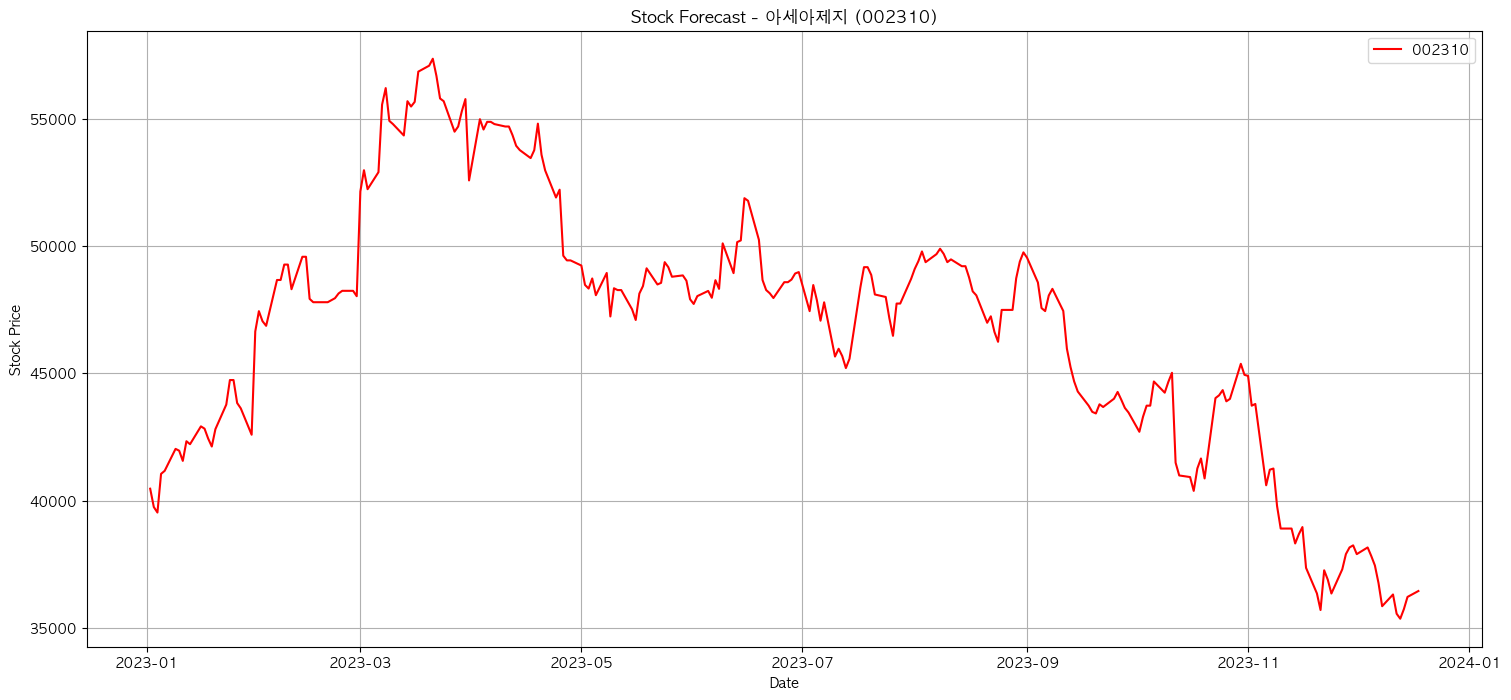

In [132]:
#5번

# 참고) 2023년은 코스피 개장일이 1월 2일 (월) 이다. 

start_date = pd.to_datetime('2023-01-02')
days = len(predict_new)
dates = pd.bdate_range(start= start_date, periods=days) #pd.date 대신 pd.bdate: 주말 뺐음. 

# Plot

plt.figure(figsize=(18,8))

plt.plot(dates, predict, label=ticker, color='red')

plt.title(f'Stock Forecast - {name} ({ticker})')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

plt.show()

In [133]:
# 이상치 확인

print( df['return'].min() , '\n')
print( df['return'].max() , '\n')

# ±0.2 범위 이내 -> 이번 데이터에선 딱히 이상치가 없어보인다. 

-0.11866869686032142 

0.16251892949777494 



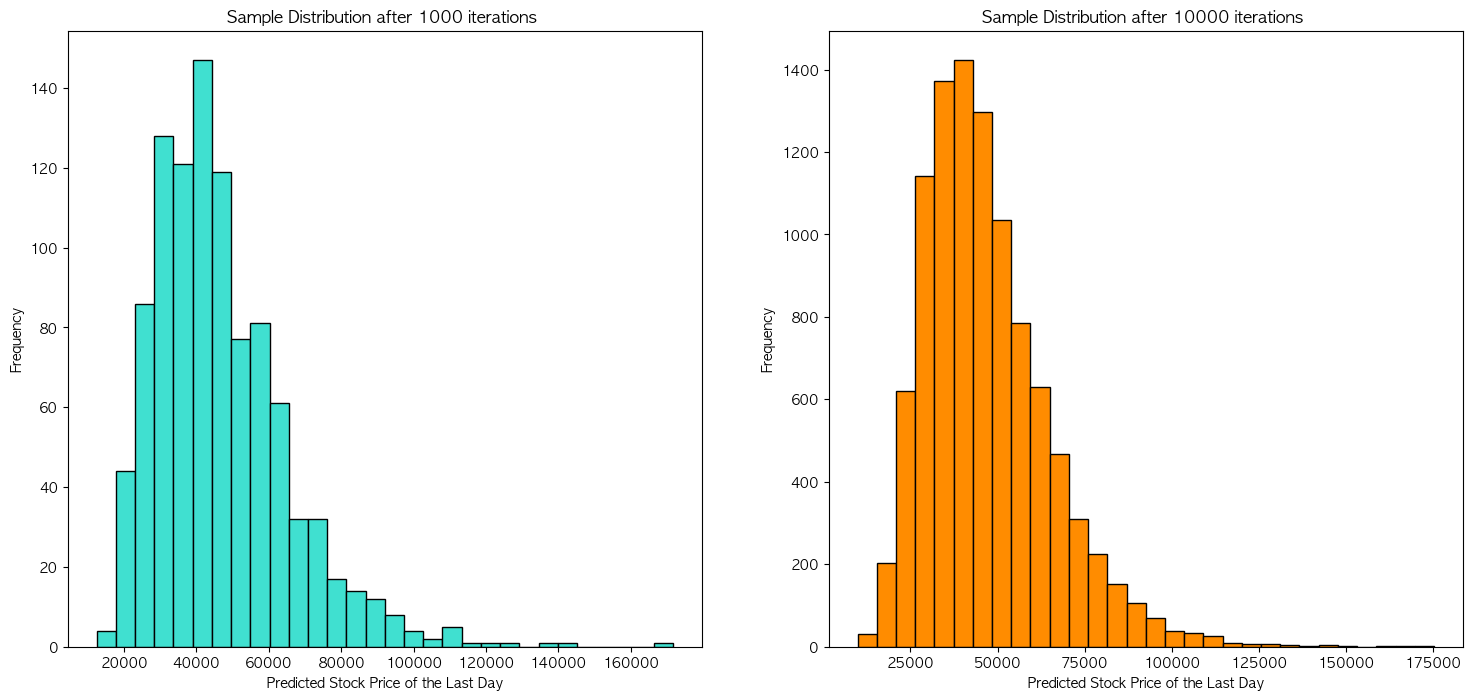

In [134]:
# 6번


n= 1000
m=10000

n_values=[]
m_values=[]

for i in range(n): 
    
    expect = np.random.choice(df['return'][:-1],size=251)
    cum_expect = np.cumsum(expect)
    last= init_price * np.exp( cum_expect )[-1]
        
    n_values.append(last)

    
for i in range(m): 
    
    expect = np.random.choice(df['return'][:-1],size=251)
    cum_expect = np.cumsum(expect)
    last= init_price * np.exp( cum_expect )[-1]
        
    m_values.append(last)    
    
# Create histogram

# Set up the figure size
plt.figure(figsize=(18,8))

## 
plt.subplot(1, 2, 1)

plt.hist(n_values, bins=30, edgecolor='black', color= 'turquoise')
plt.title(f'Sample Distribution after {n} iterations ')
plt.xlabel('Predicted Stock Price of the Last Day')
plt.ylabel('Frequency')

##
plt.subplot(1, 2, 2)

plt.hist(m_values, bins=30, edgecolor='black', color= 'darkorange')
plt.title(f'Sample Distribution after {m} iterations ')
plt.xlabel('Predicted Stock Price of the Last Day')
plt.ylabel('Frequency')

plt.show()
